# Imports #

In [1]:
# import statements
import yfinance as yf
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math

# Getting the data #

In [2]:
ticker = input("Enter ticker name: \n")
print(ticker)

AAPL


In [3]:
#Stock data is the historical stock data until one month ago
stock_data = yf.download('AAPL', start='2020-01-01', end=datetime.date.today() - datetime.timedelta(days=30))
# test_data is the stock data for the previous month
test_data = yf.download('AAPL', start = datetime.date.today() - datetime.timedelta(days=29), end = datetime.date.today())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449394,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735306,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314888,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970093,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143906,132079200


In [5]:
test_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-26,143.169998,144.250000,141.899994,143.960007,143.740540,54105100
2023-01-27,143.160004,147.229996,143.080002,145.929993,145.707520,70492800
2023-01-30,144.960007,145.550003,142.850006,143.000000,142.781998,64015300
2023-01-31,142.699997,144.339996,142.279999,144.289993,144.070023,65874500
2023-02-01,143.970001,146.610001,141.320007,145.429993,145.208282,77663600


Text(0, 0.5, 'Closing Price')

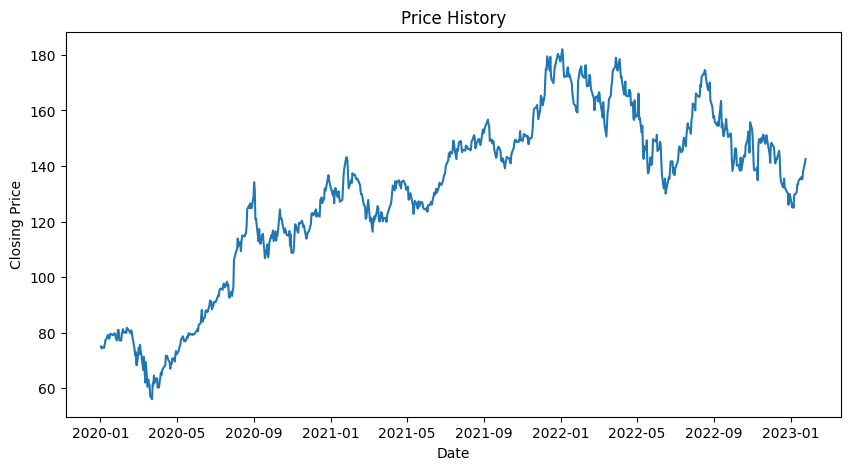

In [6]:
#Visualizing the data
plt.figure(figsize=(10, 5))
plt.title('Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

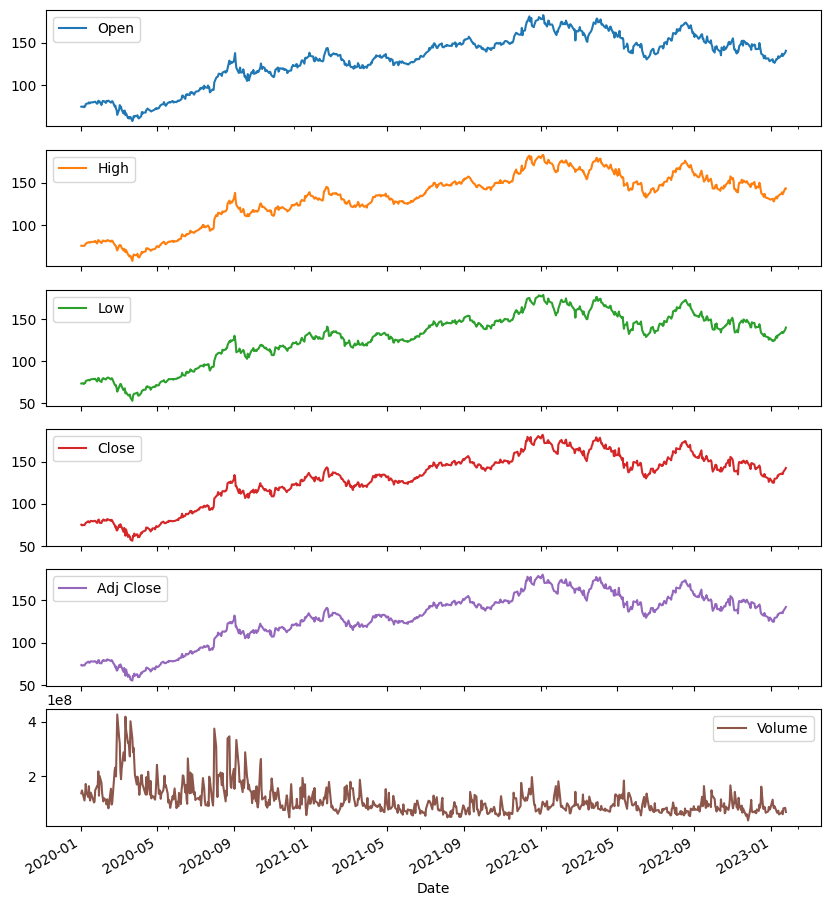

In [7]:
#Visualizing all the columns as subplots
stock_data.plot(subplots=True, figsize=(10, 12))

# Data Preprocessing #

In [8]:
#Scaling the data
sc = MinMaxScaler(feature_range=(-1, 1))
stock_data['Close'] = sc.fit_transform(stock_data['Close'].values.reshape(-1, 1))
stock_data['Close']

Date
2020-01-02   -0.698294
2020-01-03   -0.709889
2020-01-06   -0.700479
2020-01-07   -0.706077
2020-01-08   -0.687017
                ...   
2023-01-18    0.256656
2023-01-19    0.257609
2023-01-20    0.298906
2023-01-23    0.350368
2023-01-24    0.372923
Name: Close, Length: 771, dtype: float64

In [9]:
#Extracting close price data
close_data = stock_data[['Close']]

In [10]:
# convert to numpy array
data_raw = close_data.to_numpy()
data = []
    
# create all possible sequences of length seq_len
for index in range(len(data_raw) - 60): 
    data.append(data_raw[index: index + 60])


#Converting data to array and dividing it into test and train datasets    
data = np.array(data)
test_set_size = int(np.round(0.2*data.shape[0]))
train_set_size = data.shape[0] - (test_set_size)
    
x_train = data[:train_set_size,:-1,:]
y_train = data[:train_set_size,-1,:]
    
x_test = data[train_set_size:,:-1]
y_test = data[train_set_size:,-1,:]
     

In [11]:
#Checking the shapes of all datasets
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (569, 59, 1)
y_train.shape =  (569, 1)
x_test.shape =  (142, 59, 1)
y_test.shape =  (142, 1)


# Model Creation #

In [12]:
#Creating the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 59, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Compiling and fitting
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
569/569 [==============================] - 9s 12ms/step - loss: 0.0101 - acc: 0.0018
Epoch 2/3
569/569 [==============================] - 7s 12ms/step - loss: 0.0049 - acc: 0.0018
Epoch 3/3
569/569 [==============================] - 7s 12ms/step - loss: 0.0036 - acc: 0.0018


In [14]:
#Gathering prediction and calculationg the Mean Squared Error (MSE) and Root Mean Square Error (RMSE)
predict = model.predict(x_test)
MSE = np.square(np.subtract(y_test,predict)).mean() 
rmse = math.sqrt(MSE)
rmse

5/5 [==============================] - 1s 12ms/step


0.10685328733442108

In [15]:
#Gathering the original data and transforming it back to original scale
original = sc.inverse_transform(y_test)
predict = sc.inverse_transform(predict)

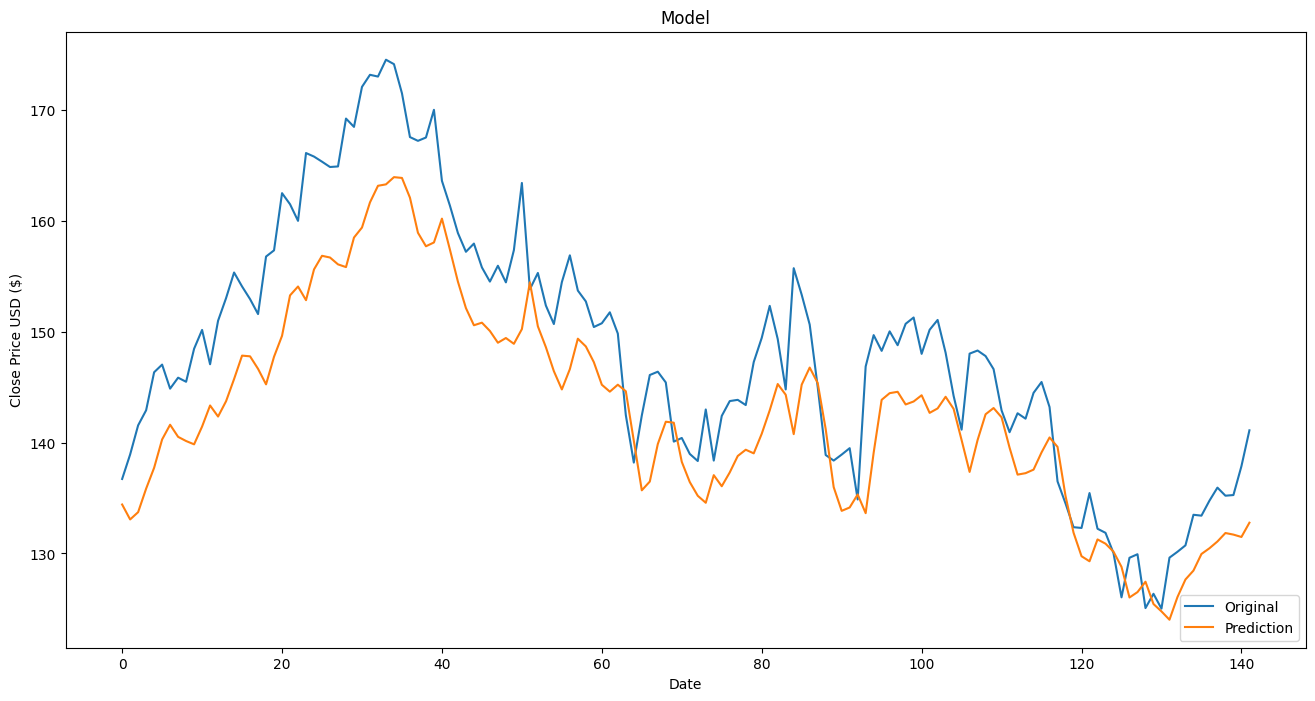

In [16]:
#Visualizing the y_test data and predicted data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(original)
plt.plot(predict)
plt.legend(['Original', 'Prediction'], loc='lower right')

plt.show()